### XGBoost for Timeseries

#### Boosting

Ensemble models are a standard tool for predictive modeling and boosting is one technique to create ensemble models.

Boosting fits a series of models and fits each successive model in order to minimize the error of the previous models.

There are a couple of variants of this concept, one being gradient boosting.

#### XGBoost

https://xgboost.readthedocs.io/

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework.

XGBoost is an ensemble of decision trees where new trees fix errors of the trees that are already part of the model. Trees are added until no further improvements can be made to the model.

Requirements to use XGBoost for time series:
- evaluate the model via walk-forward validation, instead of k-fold cross validation, as k-fold would have biased results.



In [ ]:
#!pipenv install scikit-learn xgboost --skip-lock

In [ ]:
from IPython.core.debugger import set_trace



import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

In [ ]:
df = pd.read_csv("data/MSFT-1Y-Hourly.csv")

<IPython.core.display.Javascript object>

In [ ]:
import time
import datetime
import pandas as pd

ticker = 'AAPL'
period1 = int(time.mktime(datetime.datetime(2005, 12, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2020, 12, 31, 23, 59).timetuple()))
interval = '1d' # 1d, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

df = pd.read_csv(query_string)
print(df)
df.to_csv('AAPL.csv')


            Date        Open        High         Low       Close   Adj Close  \
0     2005-12-01    2.462500    2.561786    2.457500    2.557143    2.186403   
1     2005-12-02    2.581071    2.597857    2.525000    2.593929    2.217855   
2     2005-12-05    2.569643    2.590357    2.553214    2.565000    2.193121   
3     2005-12-06    2.640357    2.672500    2.619643    2.644643    2.261217   
4     2005-12-07    2.651071    2.659286    2.611429    2.641071    2.258162   
...          ...         ...         ...         ...         ...         ...   
3792  2020-12-24  131.320007  133.460007  131.100006  131.970001  130.802338   
3793  2020-12-28  133.990005  137.339996  133.509995  136.690002  135.480591   
3794  2020-12-29  138.050003  138.789993  134.339996  134.869995  133.676666   
3795  2020-12-30  135.580002  135.990005  133.399994  133.720001  132.536850   
3796  2020-12-31  134.080002  134.740005  131.720001  132.690002  131.515976   

         Volume  
0     812893200  
1  

In [ ]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-12-01,2.462500,2.561786,2.457500,2.557143,2.186403,812893200
1,2005-12-02,2.581071,2.597857,2.525000,2.593929,2.217855,895762000
2,2005-12-05,2.569643,2.590357,2.553214,2.565000,2.193121,583671200
3,2005-12-06,2.640357,2.672500,2.619643,2.644643,2.261217,857029600
4,2005-12-07,2.651071,2.659286,2.611429,2.641071,2.258162,679464800


In [ ]:
df = df[["Close"]].copy()

In [ ]:
df.head(5)

,Close
0,2.557143
1,2.593929
2,2.565000
3,2.644643
4,2.641071


#### Transform this to a supervised learning problem.

In [ ]:
df["target"] = df.Close.shift(-1)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.head(5)

,Close,target
0,2.557143,2.593929
1,2.593929,2.565000
2,2.565000,2.644643
3,2.644643,2.641071
4,2.641071,2.645714


#### Train test split

In [ ]:
def train_test_split(data, perc):
    data = data.values
    n = int(len(data) * (1 - perc))
    return data[:n], data[n:]

In [ ]:
train, test = train_test_split(df, 0.2)

In [ ]:
print(len(df))
print(len(train))
print(len(test))

3796
3036
760


We'll use the XGBRegressor class to make a prediction. XGBRegressor is an implementation of the scikit-learn API for XGBoost regression.

We'll take the train set and test input row as input, fit a model, and make a prediction.

In [ ]:
X = train[:, :-1]
y = train[:, -1]

In [ ]:
y

array([ 2.593929,  2.565   ,  2.644643, ..., 43.587502, 43.752499,
       43.752499])

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
model.fit(X, y)

XGBRegressor(n_estimators=1000, objective='reg:squarederror')

In [ ]:
test[0]

array([43.752499, 42.642502])

In [ ]:
val = np.array(test[0, 0]).reshape(1, -1)

pred = model.predict(val)
print(pred[0])

43.70444


#### Predict
Train on train set and predict one sample at a time

In [ ]:
def xgb_predict(train, val):
    train = np.array(train)
    X, y = train[:, :-1], train[:, -1]
    model = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
    model.fit(X, y)

    val = np.array(val).reshape(1, -1)
    pred = model.predict(val)
    return pred[0]

In [ ]:
xgb_predict(train, test[0, 0])

43.70444

#### Walk-forward validation

Since we are making a one step forward prediction, in this case an hourly prediction we will predict the first record in the test dataset. 

Afterwards we add the real observation from the test set to the train set, refit the model, then predict the next step in the test dataset.

We'll evaluate the model with the RMSE metric.

In [ ]:
from sklearn.metrics import mean_squared_error


def validate(data, perc):
    predictions = []

    train, test = train_test_split(data, perc)

    history = [x for x in train]

    for i in range(len(test)):
        test_X, test_y = test[i, :-1], test[i, -1]

        pred = xgb_predict(history, test_X[0])
        predictions.append(pred)

        history.append(test[i])

    error = mean_squared_error(test[:, -1], predictions, squared=False)

    return error, test[:, -1], predictions

In [ ]:

rmse, y, pred = validate(df, 0.2)

print(rmse)

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


2.2755957088022547


In [ ]:
pred

[43.70444,
 42.50204,
 42.576283,
 42.512653,
 42.51026,
 43.231487,
 43.299816,
 42.548576,
 43.226677,
 43.665245,
 43.63959,
 43.619946,
 43.242607,
 43.675896,
 43.904892,
 44.04081,
 44.773876,
 44.767883,
 44.050697,
 44.174507,
 43.683186,
 42.471046,
 42.4752,
 42.93715,
 41.990456,
 41.883465,
 41.909733,
 39.96284,
 39.27158,
 41.364136,
 39.597206,
 38.977577,
 39.51028,
 40.550056,
 40.77145,
 41.92598,
 43.576572,
 43.260777,
 42.920788,
 42.449547,
 43.342865,
 44.121788,
 44.754013,
 44.249996,
 44.45185,
 43.568947,
 44.640156,
 44.16257,
 44.152946,
 43.272938,
 44.16637,
 44.635345,
 45.388134,
 45.34421,
 44.36334,
 44.367928,
 43.88731,
 44.264874,
 44.201538,
 42.302166,
 42.359665,
 41.807224,
 43.09286,
 42.79044,
 42.194885,
 40.442226,
 42.10536,
 41.68574,
 42.936787,
 42.33168,
 42.58411,
 42.94361,
 43.610397,
 43.081,
 43.304882,
 43.616196,
 43.847263,
 43.86654,
 43.85655,
 42.21739,
 42.091877,
 42.86615,
 40.882275,
 41.004574,
 41.828724,
 40.454823,
 

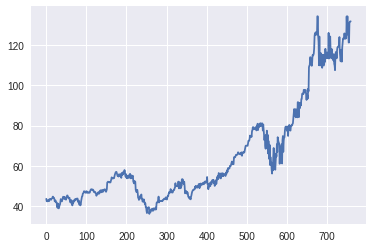

In [ ]:
plt.plot(pred, label="train")

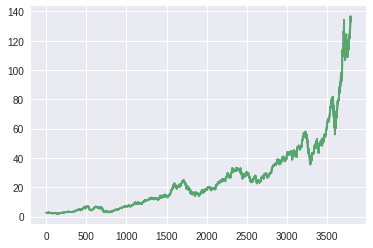

In [ ]:
plt.plot(df)